
# How the scale parameter relate to period and frequency?


The `scale` parameter used to build the transform is straightforward to use
when it is generally a ramp of integers. However it can be a bit harsh to understand
what it means exactly.
This notebook describe how scale relates to:

- period
- frequency
- child wavelet function

Intended audience: 

* Engineers ord data analysts with mild or no knowledge on wavelets analysis.

## What is the frequency associated to the scale value $s$ ?

In `pywt.scale2frequency()` the frequency associated to scale $s$ is:

$frequency = \frac{central\ frequency}{scale}$

where the _central frequency_ is a parameter of the mother wavelet chosen for the
signal analysis. See next section.

**Warning:** 

>   In `PyWavelet` the _scale_ parameter is homogenous with a period of time.
>   The mother function used at scale $s$ is built over $n$ samples with:
>   
>   $n = 2 * 8 * s$
>    
>   is *not* the same parameter than the one (let call it $s_T$ in this case) used in wavelet theory
>   which is homogenous witha  frequency.
>   
>   The theoretical wavelet child function at scale $s_T$
>   is $\Psi_{s_T}(t)$. It is scaled from the mother $\Psi(t)$ with
>   
>   $\Psi_{s_T,x}(t) = \frac{1}{\sqrt{s_T} } \frac{\Psi(t-x)}{s}$
>
>   where $x$ is the shift parameter used to convolve the signal being analysed with the wavelet.




## What is the *central frequency* of a wavelet?

Short answer: this is the ``C`` parameter in the wavelet name which has generally the form ``nameB-C``.
It is basically the frequency to which the wavelet function will be the most sensitive for scale $s=1$.

The wavelet name used with ``PyWavelet`` allow to add the parameters of the wavelet (from 0 to 3 depending on the function)

For example the name ``cmor1-1.5`` stands for *Complex Morlet* wavelet function with *bandwidth=[Hz]* and *center=1.5[Hz]*.

Let have a look to this function to make that clear.

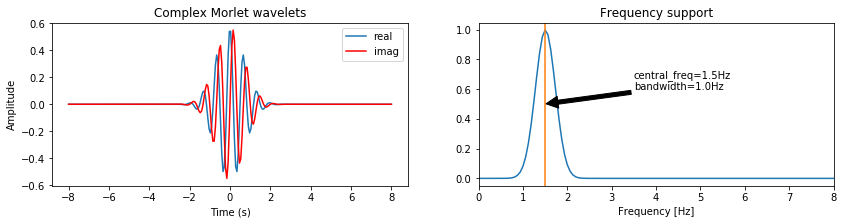

In [1]:
%matplotlib inline

import scaleogram as scg
axes = scg.plot_wav('cmor1-1.5', figsize=(14,3))

* Left plot : the mother wavelet function in time domain
* Right plot: The amplitude of the Fourier transform of the function

In the right plot (Frequency), the yellow vertical line show the location of the peak: this is the *central frequency* of the wavelet.

The bandwidth parameter selects how much the wavelet is sensitive to the frequencies around $C$. On the frequency plot it is represented by the width of the bell shaped curve (also called the *wings*).



## Which period value correspond to a given _scale_?

Short answer: $period=\frac{s}{C}$

Wavelet functions are designed to be compact in time and frequency. When looking at the plot above, you can see that the oscillations falls quickly around the center of the function. This *compactness in time* allow the scalogram to show local measurements of the signal **variations**.




## Period or *pseudo period* ?

So if you have followed this notebook from the beginning you may ask at this point:

> Wait?!   
> The previous section says that for *C=1.5Hz* as shown in the upper left plot the period is  
> $period = \frac{1}{1.5} = 0.66s$ .
> 
> If I look on the plot the signal extent is visibly over 4 seconds, not 0.66!  
> 

Well, fair enough!  

At a given scale, the wavelet sensitivity is maximum to the frequency $C$ 
but the bandwidth $B$ is non null, hence it will also probe frequency around the
*central frequency* value. This will appear on scaleogram as a smoothing effect along the Y axis.
This property will also manifest in time domain where the signal decrease *smoothly* to zero
around the maximum oscilation amplitude.

For this reason it is better to use the term of *pseudo period* to describe the
time scale.

Hopefully, in practice, this effect is generally much lower than the structure of
interrest in the wavelet transform which is dominated by the signal.  
This is covered in the next section.



## How to read the scaleograms?



### Example1: data with two periodic signals

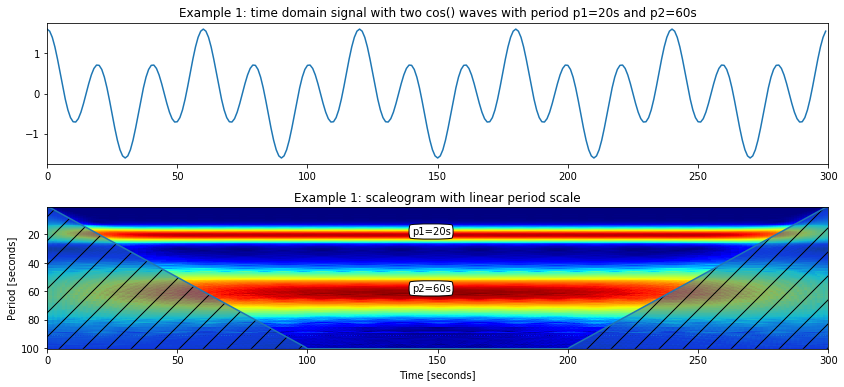

In [2]:
import numpy as np
import matplotlib.pyplot as plt
n = 300
time = np.arange(n)
p1    = 20;  f1 = 1./p1
p2    = 60; f2 = 1./p2
data = np.cos( (2*np.pi*f1) * time) + 0.6*np.cos( (2*np.pi*f2) * time)
wavelet='cmor0.7-1.5'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.3)
ax1.plot(time, data); ax1.set_xlim(0, n)
ax1.set_title('Example 1: time domain signal with two cos() waves with period p1=%ds and p2=%ds'%(p1,p2))
ax2 = scg.cws(time, data, scales=np.arange(1, 150), wavelet=wavelet,
        ax=ax2, cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title='Example 1: scaleogram with linear period scale')
txt = ax2.annotate("p1=%ds" % p1, xy=(n/2,p1), xytext=(n/2-10, p1), bbox=dict(boxstyle="round4", fc="w"))
txt = ax2.annotate("p2=%ds" % p2, xy=(n/2,p2), xytext=(n/2-10, p2), bbox=dict(boxstyle="round4", fc="w"))


* You can observe on Example 1 scaleogram:

   * That the two periodic signals do appear as continuous lines along the time axis (X).   
    It shows that the wavelet perfectly captures the signal at its frequency of sensitivity.  
    
   * That the visible height of the two signals expands with the scale value.  
    This is absolutely normal as the wavelet signal is scaled by a factor $s$.


### Example 2: Effect of the bandwith parameter (smoothing)

In the second example the bandwith parameter is multiplied by a factor 3

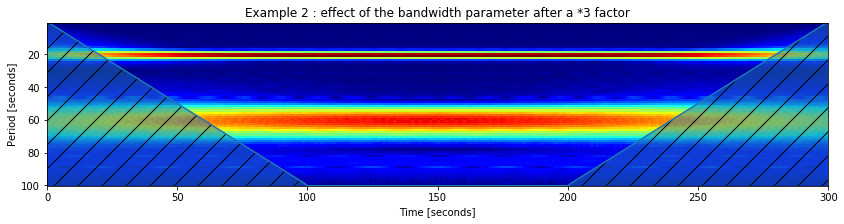

In [3]:

wavelet2 = 'cmor3-1.5'
ax3 = scg.cws(time, data, scales=np.arange(1, 150, 2), wavelet=wavelet2,
        figsize=(14, 3), cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 2 : effect of the bandwidth parameter after a *3 factor")


You can observe in the scaleogram of example 2 that the height of both bars has significantly shrinked.

The bandwith parameter allow to tune the sensitivity on the period axis (Y). Or in other words the visibl amount of smoothin.

Useful range is between 0.5 and 2 (may vary with the chosen wavelet), other values can cause rippling and various side effects due to numerical limitation from the finite nuber of samples of the data and wavelet function.


### Example 3 : effect of  holes in data

In real life, data has holes, or the observed phenomenon amplitude can vary over time.

The following example has a hole at the beginning and a ramp to zero is applyed at the end. 

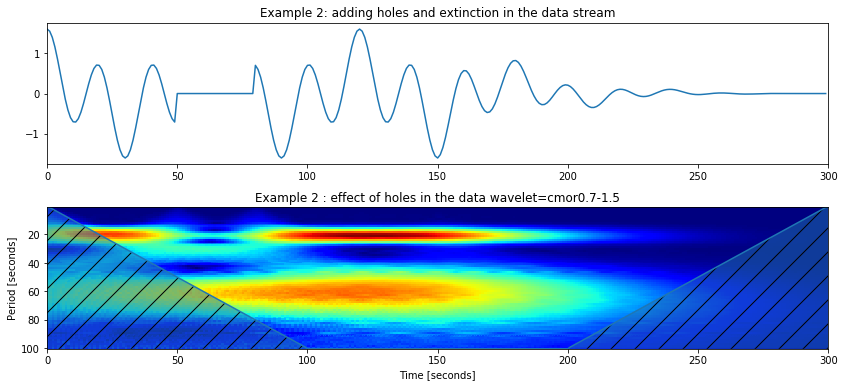

In [10]:
data2 = data
data2[50:80] = 0
data2[150:n] *= np.arange(n-150, 0, -1)/(n-150)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.3)
ax1.plot(time, data2); ax1.set_xlim(0, n)
ax1.set_title('Example 2: adding holes and extinction in the data stream')

ax2 = scg.cws(time, data2, scales=np.arange(1, 150, 2), wavelet=wavelet,
        ax=ax2, cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 3 : effect of holes in the data wavelet="+wavelet)


As you can see, the scale influence not only the sensitivity on the Y axis but has also a smoothing effect on the X axis: the second cos() line at period $p2=60$ does not "see" the first hole in the data, but the signal amplitude has diminished.  

The second observation is the apparition on a spurious line at *period=40*. This is due to the sharp cut applyied on the data between 50 and 100 (This effect is called aliasing in frequency).  
Note that missing data filled wit zeroes will have this kind of effect.

For a better understanding of the notion of scaling of the wavelet, let have a look at the child wavelet used to produce the lines at p1 (scale=~27) and p2 (scale=~90).
The two 

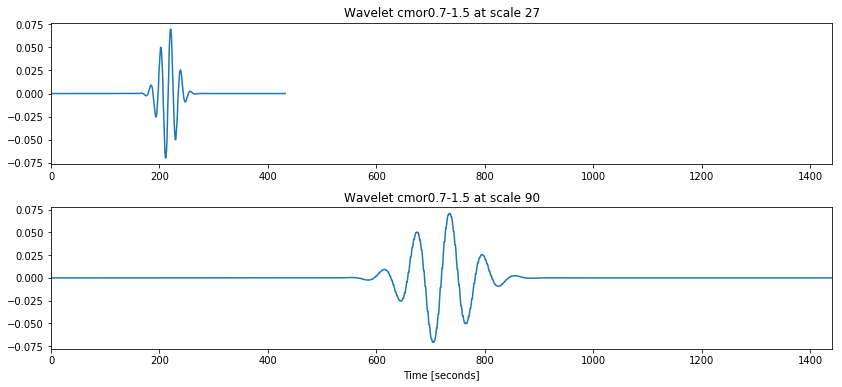

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.3)

s1 = 27; s2 = 90
child1 = scg.child_wav(wavelet, 27)
child2 = scg.child_wav(wavelet, 90)
ax1.plot(child1.real)
ax1.set_title("Wavelet "+wavelet+ " at scale "+str(s1))
ax1.set_xlim(0, len(child2))

ax2.plot(child2.real)
ax2.set_title("Wavelet "+wavelet+ " at scale "+str(s2))
xlim = ax2.set_xlim(0, len(child2))
text = ax2.set_xlabel("Time [seconds]")

From the inspection of child wavelet it is visible that the signal extension match the observed smoothing on the X axis.

One can note also that the support of the wavelets is larger than the signal being studied.  
Has most of the child values are close to zero, it is 

## Tip: passing the Y axis in logscale

The ``scaleogram`` module has a robust support for logarithmic scale axes.

With logscale on Y axis, the bandwith will have the same height at all scales which may be helpful for data interpretation.

Let's try it by setting the ``yscale='log'`` parameter!

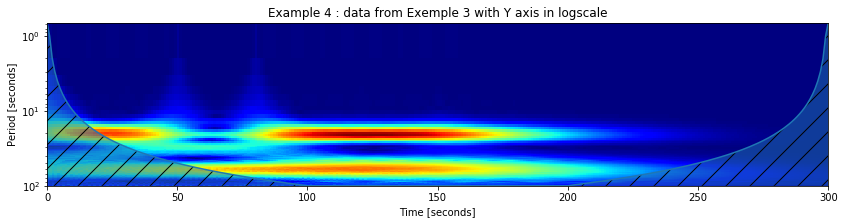

In [12]:
ax2 = scg.cws(time, data2, scales=np.arange(1, 150, 2), wavelet=wavelet,
        figsize=(14, 3), cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 4 : data from Exemple 3 with Y axis in logscale",
        yscale='log')

OK now the two cos() signals appear with the same visual height on the scaleogram!  
The drawback is that now the lecture precision of the period is lessened.

Note that the smoothing effect on the time (X) axis is still present.

## Conclusion


In this notebook we have seen the meaning of the scale parameter. It has been considered in relation to the frequency and period of the meaningful features in the data.

The main idea is that there is a compromise between time and frequency resolution.

I hope this page has been useful for you, have fun with wavelet based analysis.


## See also

* [Continuous Wavelet Transform and Scale-Based Analysis](https://fr.mathworks.com/help/wavelet/gs/continuous-wavelet-transform-and-scale-based-analysis.html)


## Author

Alexandre Sauvé (2019)

The [scaleogram](http://github.com/alsauve/scaleogram) module
